In [35]:
import pandas as pd
import numpy as np

# Load the provided CSV files
wd = '/Users/neilgrigg/Desktop/citadelEQR/'

df_index_returns = pd.read_csv(wd+'/data/IndexReturns.csv')
df_stock_data = pd.read_csv(wd+'/data/StockData.csv')
df_stock_returns = pd.read_csv(wd+'/data/StockReturns.csv')
df_sizing_data = pd.read_csv(wd+'/data/SizingData.csv')

In [36]:
def calculate_annualized_return(daily_returns, standard_days=252):
    """
    Calculate the annualized return given daily returns, adjusting for a non-standard number of trading days.
    
    NOTE: For this problem, we are NOT given exactly 1 year, so I adjust for this slight correction. 
    
    :param daily_returns: Pandas Series of daily returns
    :param actual_days: Actual number of days in the data (default 250)
    :param standard_days: Standard number of trading days in a year (default 252)
    :return: Annualized return
    """
    cumulative_return = (1 + daily_returns).prod()
    
    business_days_in_data = len(daily_returns) - 1
    
    # Adjusting for the actual number of days
    annualized_factor = standard_days / business_days_in_data
    adjusted_cumulative_return = cumulative_return ** annualized_factor

    annualized_return = adjusted_cumulative_return - 1
    return annualized_return

# Convert the 'Dates' column to datetime
df_stock_returns['Dates'] = pd.to_datetime(df_stock_returns['Dates'])

In [37]:
def annualized_std_dev_from_daily_returns(daily_returns, days_per_year=252):
    """
    Annualize the standard deviation of daily returns.

    :param daily_returns: Pandas Series of daily returns.
    :param days_per_year: Number of trading days in a year, typically 252 for standard business days.
    :return: Annualized standard deviation.
    """
    # Calculate the daily standard deviation of returns
    daily_std_dev = daily_returns.std()

    # Annualize the standard deviation
    annualized_std_dev = daily_std_dev * (days_per_year ** 0.5)
    return annualized_std_dev

In [38]:
def sharpe_ratio(annualized_return, annualized_std_dev, risk_free_rate=0.02):
    """
    Calculate the Sharpe Ratio for a stock.
    
    NOTE: Assumes standard deviation of risk free asset is zero.

    :param annualized_return: Annualized return of the stock.
    :param annualized_std_dev: Annualized standard deviation (volatility) of the stock's returns.
    :param risk_free_rate: Risk-free rate, default is 2% (0.02).
    :return: Sharpe Ratio.
    """
    return (annualized_return - risk_free_rate) / annualized_std_dev

In [39]:
def add_equal_weight_portfolio_weights(df_stock_data):
    """
    Add a column of equal-weighted portfolio weights to the stock data DataFrame.

    :param stock_data_df: DataFrame containing stock data.
    :param stock_returns_df: DataFrame of stock returns, first column is assumed to be dates.
    :return: DataFrame with an added column for equal-weighted portfolio weights.
    """
    # Number of securities is the number of columns in stock_returns_df minus the date column
    num_securities = len(df_stock_data)

    # Calculate equal weights for each security
    equal_weight = 1 / num_securities

    # Add the equal-weighted portfolio weights to the stock_data_df
    df_stock_data['equal_weight'] = equal_weight

    return df_stock_data

# Apply the function to add equal-weighted portfolio weights to df_stock_data
df_stock_data = add_equal_weight_portfolio_weights(df_stock_data)
df_stock_data.head()


,Symbol,Price,MarketCap,ShareOutstanding,EPS,FactorZScore,equal_weight
0,AAPL,151.01,2389273,15822,6.199,-0.38,0.01
1,MSFT,263.10,1958465,7444,9.934,-0.64,0.01
2,GOOGL,94.57,563259,5956,5.649,-0.87,0.01
3,AMZN,97.61,1000235,10247,2.727,-1.28,0.01
4,BRK/B,309.89,403471,1302,15.222,0.40,0.01


In [40]:
import numpy as np

def add_annualized_volatility(df_returns, days_per_year=252):
    """
    Calculate the annualized volatility for a DataFrame of returns.
    This function is adapted to handle both multiple and single column DataFrames 
    and also skips non-numeric columns.

    :param df_returns: DataFrame containing daily returns. Can be multiple columns (stocks) or a single column.
    :param days_per_year: Number of trading days in a year, typically 252 for standard business days.
    :return: DataFrame with columns and their corresponding annualized volatility if multiple columns are provided,
             or a single value of annualized volatility if only one column is provided.
    """
    # Select only numeric columns
    df_numeric = df_returns.select_dtypes(include=[np.number])

    # Check if the DataFrame has multiple columns or just one
    if len(df_numeric.columns) > 1:
        # If multiple columns, calculate annualized volatility for each column
        annualized_vols = {stock: np.sqrt(df_numeric[stock].var() * days_per_year) for stock in df_numeric.columns}
        # Convert the dictionary to a DataFrame
        annualized_vols_df = pd.DataFrame(list(annualized_vols.items()), columns=['Symbol', 'ann_vol'])
        return annualized_vols_df
    else:
        # If only one column, calculate annualized volatility for that column
        daily_returns = df_numeric[df_numeric.columns[0]]
        annualized_vol = np.sqrt(daily_returns.var() * days_per_year)
        return annualized_vol

# Apply the function
df_annualized_volatility = add_annualized_volatility(df_stock_returns)
ann_vol_series = df_annualized_volatility.set_index('Symbol')['ann_vol']
df_stock_data['ann_vol'] = df_stock_data['Symbol'].map(ann_vol_series)

# Add a P/E ratio column
df_stock_data['P/E Ratio'] = df_stock_data['Price'] / df_stock_data['EPS']

df_stock_data.head()

,Symbol,Price,MarketCap,ShareOutstanding,EPS,FactorZScore,equal_weight,ann_vol,P/E Ratio
0,AAPL,151.01,2389273,15822,6.199,-0.38,0.01,0.356964,24.360381
1,MSFT,263.10,1958465,7444,9.934,-0.64,0.01,0.353120,26.484800
2,GOOGL,94.57,563259,5956,5.649,-0.87,0.01,0.386506,16.741016
3,AMZN,97.61,1000235,10247,2.727,-1.28,0.01,0.500773,35.793913
4,BRK/B,309.89,403471,1302,15.222,0.40,0.01,0.225545,20.358034


In [41]:
def add_annualized_return(stock_data_df, stock_returns_df):
    """
    Add a column of annualized return to the stock data DataFrame.

    :param stock_data_df: DataFrame containing stock data.
    :param stock_returns_df: DataFrame containing daily returns for each stock.
    :return: DataFrame with an added column for annualized return.
    """
    # Initialize a dictionary to hold annualized returns
    annualized_returns = {}

    for stock in stock_data_df['Symbol']:
        if stock in stock_returns_df.columns:
            # Calculate annualized return for each stock
            daily_returns = stock_returns_df[stock]
            annualized_return = calculate_annualized_return(daily_returns)
            annualized_returns[stock] = annualized_return

    return annualized_returns        
    
# Assuming df_stock_returns is already created from StockReturns.csv
# Apply the function to add annualized return
df_annualized_returns = add_annualized_return(df_stock_data, df_stock_returns)
df_stock_data['ann_return'] = df_stock_data['Symbol'].map(df_annualized_returns)
df_stock_data.head()


,Symbol,Price,MarketCap,ShareOutstanding,EPS,FactorZScore,equal_weight,ann_vol,P/E Ratio,ann_return
0,AAPL,151.01,2389273,15822,6.199,-0.38,0.01,0.356964,24.360381,-0.265843
1,MSFT,263.10,1958465,7444,9.934,-0.64,0.01,0.353120,26.484800,-0.282053
2,GOOGL,94.57,563259,5956,5.649,-0.87,0.01,0.386506,16.741016,-0.393310
3,AMZN,97.61,1000235,10247,2.727,-1.28,0.01,0.500773,35.793913,-0.498907
4,BRK/B,309.89,403471,1302,15.222,0.40,0.01,0.225545,20.358034,0.033384


In [42]:
def add_sharpe_ratio_column(df_returns, risk_free_rate=0.02):
    """
    Calculate the Sharpe Ratio for each column in the returns DataFrame.

    :param df_returns: DataFrame containing daily returns. Can be multiple columns (stocks) or a single column.
    :param risk_free_rate: Risk-free rate, default is 2% (0.02).
    :return: DataFrame with columns and their corresponding Sharpe Ratios if multiple columns are provided,
             or a single value of Sharpe Ratio if only one column is provided.
    """
    # Define a function to calculate the Sharpe Ratio
    def sharpe_ratio(ann_return, ann_vol, risk_free_rate=0.02):
        return (ann_return - risk_free_rate) / ann_vol if ann_vol != 0 else None

    # Select only numeric columns
    df_numeric = df_returns.select_dtypes(include=[np.number])

    # Check if the DataFrame has multiple columns or just one
    if len(df_numeric.columns) > 1:
        # If multiple columns, calculate Sharpe Ratio for each column
        sharpe_ratios = df_numeric.apply(
            lambda row: sharpe_ratio(row['ann_return'], row['ann_vol'], risk_free_rate), axis=1)
        return sharpe_ratios
    else:
        # If only one column, calculate Sharpe Ratio for that column
        ann_return = df_numeric['ann_return'].iloc[0]
        ann_vol = df_numeric['ann_vol'].iloc[0]
        return sharpe_ratio(ann_return, ann_vol, risk_free_rate)
    
# Adjusted function call - assuming df_stock_data has 'ann_return' and 'ann_vol' columns
sharpe_ratios = add_sharpe_ratio_column(df_stock_data[['ann_return', 'ann_vol']])

# If sharpe_ratios is a Series, directly assign it to df_stock_data
df_stock_data['sharpe_ratio'] = sharpe_ratios

df_stock_data



,Symbol,Price,MarketCap,ShareOutstanding,EPS,FactorZScore,equal_weight,ann_vol,P/E Ratio,ann_return,sharpe_ratio
0,AAPL,151.01,2389273,15822,6.199,-0.38,0.01,0.356964,24.360381,-0.265843,-0.800760
1,MSFT,263.10,1958465,7444,9.934,-0.64,0.01,0.353120,26.484800,-0.282053,-0.855384
2,GOOGL,94.57,563259,5956,5.649,-0.87,0.01,0.386506,16.741016,-0.393310,-1.069349
3,AMZN,97.61,1000235,10247,2.727,-1.28,0.01,0.500773,35.793913,-0.498907,-1.036212
4,BRK/B,309.89,403471,1302,15.222,0.40,0.01,0.225545,20.358034,0.033384,0.059342
...,...,...,...,...,...,...,...,...,...,...,...
95,REGN,757.61,81449,108,41.455,0.84,0.01,0.337029,18.275479,0.143673,0.366949
96,PGR,138.73,81143,585,6.532,1.19,0.01,0.257309,21.238518,0.270395,0.973129
97,SLB,56.36,80042,1420,3.026,2.75,0.01,0.498097,18.625248,0.820792,1.607704
98,EOG,134.14,78792,587,13.539,2.60,0.01,0.449031,9.907674,0.574550,1.234993


In [43]:
def add_volatility_weighted_portfolio_weights(stock_data_df, volatility_col_name):
    """
    Add a column of volatility-weighted portfolio weights to the stock data DataFrame.

    :param stock_data_df: DataFrame containing stock data.
    :param volatility_col_name: The name of the column containing annualized volatilities.
    :return: DataFrame with an added column for volatility-weighted portfolio weights.
    """
    # Check if the specified volatility column exists in the DataFrame
    if volatility_col_name not in stock_data_df.columns:
        raise ValueError("Error: Specified column name does not exist in DataFrame")

    # Calculate the denominator which is the sum of 1/stdev of all securities
    denominator = (1 / stock_data_df[volatility_col_name]).sum()

    # Calculate volatility weighting for each stock
    stock_data_df['vol_weight'] = (1 / stock_data_df[volatility_col_name]) / denominator

    # Check if the sum of the new column is approximately 1 (or 100%)
    if not abs(stock_data_df['vol_weight'].sum() - 1) < 1e-5:
        raise ValueError("Error: Sum of weights does not add up to 1")

    return stock_data_df

# Apply the function to add volatility-weighted portfolio weights to df_stock_data
try:
    df_stock_data = add_volatility_weighted_portfolio_weights(df_stock_data, 'ann_vol')
except ValueError as e:
    print(e)
    # Optionally handle the error, e.g., by logging, or proceed with caution


In [44]:
def add_market_cap_weighted_portfolio_weights(stock_data_df):
    """
    Add a column of market cap-weighted portfolio weights to the stock data DataFrame.

    :param stock_data_df: DataFrame containing stock data with market caps.
    :return: DataFrame with an added column for market cap-weighted portfolio weights.
    """
    # Calculate the denominator which is the sum of all market caps
    denominator = stock_data_df['MarketCap'].sum()

    # Calculate market cap weighting for each stock
    stock_data_df['market_cap_weight'] = stock_data_df['MarketCap'] / denominator

    # Check if the sum of the new column is approximately 1 (or 100%)
    if not abs(stock_data_df['market_cap_weight'].sum() - 1) < 1e-5:
        return "Error: Sum of weights does not add up to 1"

    return stock_data_df

# Apply the function to add market cap-weighted portfolio weights to df_stock_data
df_stock_data = add_market_cap_weighted_portfolio_weights(df_stock_data)
df_stock_data.head()


,Symbol,Price,MarketCap,ShareOutstanding,EPS,FactorZScore,equal_weight,ann_vol,P/E Ratio,ann_return,sharpe_ratio,vol_weight,market_cap_weight
0,AAPL,151.01,2389273,15822,6.199,-0.38,0.01,0.356964,24.360381,-0.265843,-0.800760,0.008743,0.101539
1,MSFT,263.10,1958465,7444,9.934,-0.64,0.01,0.353120,26.484800,-0.282053,-0.855384,0.008839,0.083230
2,GOOGL,94.57,563259,5956,5.649,-0.87,0.01,0.386506,16.741016,-0.393310,-1.069349,0.008075,0.023937
3,AMZN,97.61,1000235,10247,2.727,-1.28,0.01,0.500773,35.793913,-0.498907,-1.036212,0.006233,0.042508
4,BRK/B,309.89,403471,1302,15.222,0.40,0.01,0.225545,20.358034,0.033384,0.059342,0.013838,0.017147


In [45]:
# Calculate the daily returns of the equally weighted portfolio
# Extracting the daily returns from df_stock_returns (excluding the date column)
daily_returns = df_stock_returns.drop(columns=['Dates'])

# Create a Series or numpy array of equal weights
equal_weight = 1 / len(daily_returns.columns)
equal_weights = pd.Series(equal_weight, index=daily_returns.columns)

# Extract the weights from stock_data_df
vol_weights = df_stock_data.set_index('Symbol')['vol_weight']
market_cap_weights = df_stock_data.set_index('Symbol')['market_cap_weight']

# Ensure the weights align with the columns in daily_returns
vol_weights = vol_weights[daily_returns.columns]
market_cap_weights = market_cap_weights[daily_returns.columns]

# Multiply the daily returns by each set of weights and sum across columns for each row
portfolio_returns_equal_weight = daily_returns.multiply(equal_weights, axis=1).sum(axis=1)
portfolio_returns_vol_weight = daily_returns.multiply(vol_weights, axis=1).sum(axis=1)
portfolio_returns_market_cap_weight = daily_returns.multiply(market_cap_weights, axis=1).sum(axis=1)

# Combine the portfolio returns into a single DataFrame
df_portfolio_returns = pd.DataFrame({
    'Date': df_stock_returns['Dates'],
    'Equal Weight': portfolio_returns_equal_weight,
    'Volatility Weight': portfolio_returns_vol_weight,
    'Market Cap Weight': portfolio_returns_market_cap_weight
})

# Set the 'Date' column as the index
df_portfolio_returns.set_index('Date', inplace=True)

# Display the first few rows of the DataFrame
df_portfolio_returns.head()


,Equal Weight,Volatility Weight,Market Cap Weight
Date,,,
2022-01-03,0.006444,0.004454,0.010718
2022-01-04,0.003935,0.004865,-0.001625
2022-01-05,-0.013150,-0.009419,-0.016883
2022-01-06,0.000306,-0.000405,-0.002563
2022-01-07,-0.002261,-0.000336,-0.002639


In [46]:
# Calculate the annualized return for each type of portfolio
annualized_return_equal_weight = calculate_annualized_return(df_portfolio_returns['Equal Weight'])
annualized_return_volatility_weight = calculate_annualized_return(df_portfolio_returns['Volatility Weight'])
annualized_return_market_cap_weight = calculate_annualized_return(df_portfolio_returns['Market Cap Weight'])

# Calculate annualized volatility for each portfolio type
annualized_volatility_equal_weight = add_annualized_volatility(df_portfolio_returns[['Equal Weight']])
annualized_volatility_volatility_weight = add_annualized_volatility(df_portfolio_returns[['Volatility Weight']])
annualized_volatility_market_cap_weight = add_annualized_volatility(df_portfolio_returns[['Market Cap Weight']])

# Calculate Sharpe Ratio for each portfolio type
sharpe_ratio_equal_weight = sharpe_ratio(annualized_return_equal_weight, annualized_volatility_equal_weight)
sharpe_ratio_volatility_weight = sharpe_ratio(annualized_return_volatility_weight, annualized_volatility_volatility_weight)
sharpe_ratio_market_cap_weight = sharpe_ratio(annualized_return_market_cap_weight, annualized_volatility_market_cap_weight)

# Create a new DataFrame with the calculated metrics
df_portfolio_data = pd.DataFrame({
    'ann_return': [annualized_return_equal_weight, annualized_return_volatility_weight, annualized_return_market_cap_weight],
    'ann_volatility': [annualized_volatility_equal_weight, annualized_volatility_volatility_weight, annualized_volatility_market_cap_weight],
    'sharpe_ratio': [sharpe_ratio_equal_weight, sharpe_ratio_volatility_weight, sharpe_ratio_market_cap_weight]
}, index=['Equal Weight', 'Volatility Weight', 'Market Cap Weight'])

# Output the DataFrame
print(df_portfolio_data)


                   ann_return  ann_volatility  sharpe_ratio
Equal Weight        -0.084707        0.226386     -0.462513
Volatility Weight   -0.040105        0.204311     -0.294183
Market Cap Weight   -0.146779        0.249234     -0.669168


In [47]:
import pandas as pd
from scipy.stats import hmean

def calculate_weighted_harmonic_mean(weights, multiples):
    """
    Calculate the weighted harmonic mean of valuation multiples.

    :param weights: Pandas Series or numpy array containing the weights for each stock.
    :param multiples: Pandas Series or numpy array containing the valuation multiples for each stock.
    :return: Weighted harmonic mean of the valuation multiples.
    """
    # Ensure weights sum to 1
    normalized_weights = weights / weights.sum()

    # Calculate weighted harmonic mean
    weighted_multiples = normalized_weights / multiples
    return 1 / weighted_multiples.sum()

# Extracting the weights and P/E ratios from df_stock_data
multiples = df_stock_data['P/E Ratio']
equal_weights = df_stock_data['equal_weight']
portfolio_pe_harmonic_mean_equal_weight = calculate_weighted_harmonic_mean(equal_weights, multiples)

# Extracting market cap weights and calculating the harmonic mean for market cap weighted portfolio
market_cap_weights = df_stock_data['market_cap_weight']
portfolio_pe_harmonic_mean_market_cap = calculate_weighted_harmonic_mean(market_cap_weights, multiples)

# Extracting volatility weights and calculating the harmonic mean for volatility weighted portfolio
vol_weights = df_stock_data['vol_weight']
portfolio_pe_harmonic_mean_vol = calculate_weighted_harmonic_mean(vol_weights, multiples)


# Add the calculated figures to df_portfolio_data under the respective rows
df_portfolio_data.loc['Equal Weight', 'Harmonic Mean P/E'] = portfolio_pe_harmonic_mean_equal_weight
df_portfolio_data.loc['Market Cap Weight', 'Harmonic Mean P/E'] = portfolio_pe_harmonic_mean_market_cap
df_portfolio_data.loc['Volatility Weight', 'Harmonic Mean P/E'] = portfolio_pe_harmonic_mean_vol

# Display the updated DataFrame
print(df_portfolio_data)

                   ann_return  ann_volatility  sharpe_ratio  Harmonic Mean P/E
Equal Weight        -0.084707        0.226386     -0.462513          17.956437
Volatility Weight   -0.040105        0.204311     -0.294183          17.295909
Market Cap Weight   -0.146779        0.249234     -0.669168          19.441343


In [48]:
def calculate_beta(security_returns, market_returns):
    # Calculate covariance using np.cov (which by default uses sample statistics)
    covariance = np.cov(security_returns, market_returns)[0, 1]

    # Calculate variance of the market returns using sample statistics (ddof=1)
    market_variance = np.var(market_returns, ddof=1)

    # Calculate beta
    beta = covariance / market_variance
    return beta

def add_beta_to_stock_data(stock_data_df, stock_returns_df, market_returns_df):
    # Align dates in both stock and market returns DataFrames
    stock_returns_df['Date'] = pd.to_datetime(stock_returns_df['Dates'])
    market_returns_df['Date'] = pd.to_datetime(market_returns_df['Date'])

    # Merge the stock returns with market returns on the Date column
    merged_df = pd.merge(stock_returns_df, market_returns_df, on='Date')

    for stock in stock_data_df['Symbol']:
        if stock in merged_df.columns:
            beta = calculate_beta(merged_df[stock], merged_df['Return'])
            stock_data_df.loc[stock_data_df['Symbol'] == stock, 'Beta'] = beta

    return stock_data_df, merged_df  # Returning both DataFrames

# Add beta to the stock data DataFrame and get merged_df
df_stock_data, merged_df = add_beta_to_stock_data(df_stock_data, df_stock_returns, df_index_returns)

# Now you can inspect merged_df
print(merged_df.head())


       Dates      AAPL      MSFT     GOOGL      AMZN     BRK/B      TSLA  \
0 2022-01-03  0.025004 -0.004668  0.000963  0.022118  0.005987  0.135317   
1 2022-01-04 -0.012692 -0.017147 -0.004083 -0.016916  0.025732 -0.041833   
2 2022-01-05 -0.026600 -0.038388 -0.045876 -0.018893  0.004505 -0.053471   
3 2022-01-06 -0.016693 -0.007902 -0.000200 -0.006711  0.010648 -0.021523   
4 2022-01-07  0.000988  0.000510 -0.005303 -0.004288  0.020944 -0.035447   

       NVDA       XOM         V  ...      ISRG       MMC        MO      REGN  \
0  0.024141  0.038405  0.021780  ...  0.001948 -0.037913  0.012239 -0.006999   
1 -0.027589  0.037614  0.004652  ... -0.014917 -0.000478  0.022097 -0.016393   
2 -0.057562  0.012437 -0.011058  ... -0.035756 -0.013880 -0.007954 -0.035180   
3  0.020794  0.023521 -0.001136  ... -0.022723  0.011284  0.011719  0.005579   
4 -0.033040  0.008197 -0.012696  ... -0.029595 -0.017278  0.011380  0.008840   

        PGR       SLB       EOG       TGT       Date    Return

In [49]:
# Calculate total return of the index
index_annualized_return = calculate_annualized_return(df_index_returns['Return'])

# Calculate excess return for each security
df_stock_data['Excess Return'] = df_stock_data['ann_return'] - df_stock_data['Beta'] * index_annualized_return - 0.02

df_stock_data

,Symbol,Price,MarketCap,ShareOutstanding,EPS,FactorZScore,equal_weight,ann_vol,P/E Ratio,ann_return,sharpe_ratio,vol_weight,market_cap_weight,Beta,Excess Return
0,AAPL,151.01,2389273,15822,6.199,-0.38,0.01,0.356964,24.360381,-0.265843,-0.800760,0.008743,0.101539,1.307697,-0.047090
1,MSFT,263.10,1958465,7444,9.934,-0.64,0.01,0.353120,26.484800,-0.282053,-0.855384,0.008839,0.083230,1.282991,-0.067811
2,GOOGL,94.57,563259,5956,5.649,-0.87,0.01,0.386506,16.741016,-0.393310,-1.069349,0.008075,0.023937,1.342847,-0.168140
3,AMZN,97.61,1000235,10247,2.727,-1.28,0.01,0.500773,35.793913,-0.498907,-1.036212,0.006233,0.042508,1.640393,-0.219413
4,BRK/B,309.89,403471,1302,15.222,0.40,0.01,0.225545,20.358034,0.033384,0.059342,0.013838,0.017147,0.755812,0.151376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,REGN,757.61,81449,108,41.455,0.84,0.01,0.337029,18.275479,0.143673,0.366949,0.009261,0.003461,0.586137,0.230686
96,PGR,138.73,81143,585,6.532,1.19,0.01,0.257309,21.238518,0.270395,0.973129,0.012130,0.003448,0.543192,0.349568
97,SLB,56.36,80042,1420,3.026,2.75,0.01,0.498097,18.625248,0.820792,1.607704,0.006266,0.003402,0.677474,0.924482
98,EOG,134.14,78792,587,13.539,2.60,0.01,0.449031,9.907674,0.574550,1.234993,0.006951,0.003348,0.669787,0.676836


/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

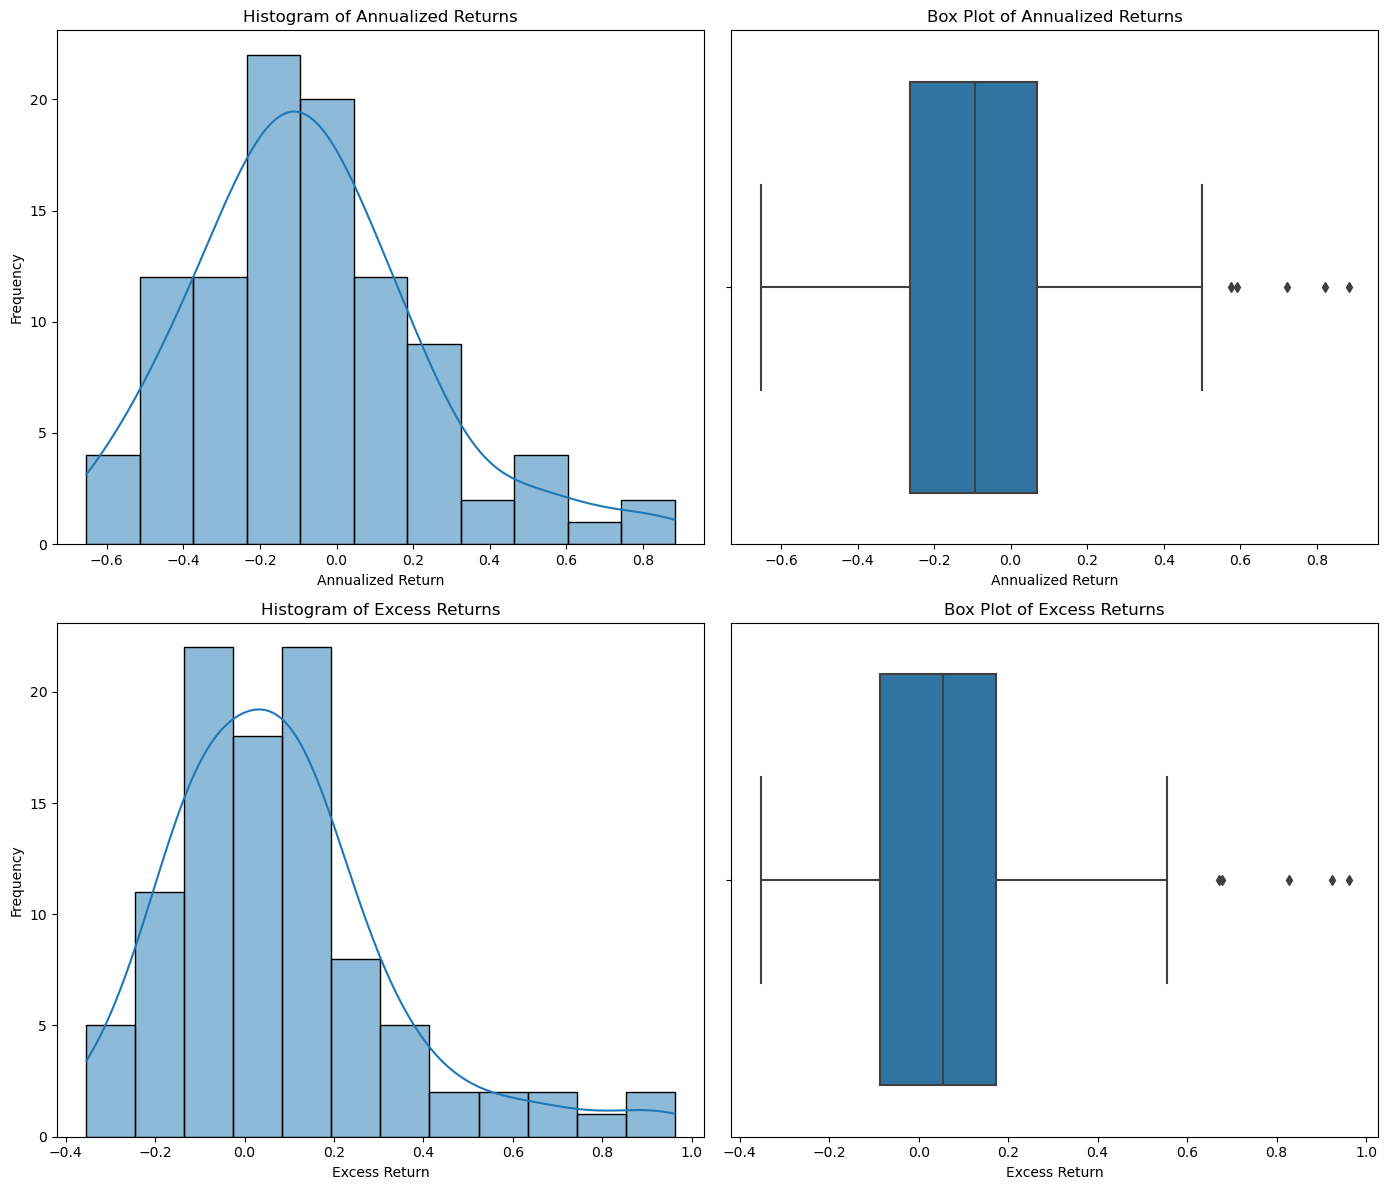

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_stock_data_with_ann_return contains the 'ann_return' column
# and df_stock_data_with_excess_return contains the 'Excess Return' column
plt.figure(figsize=(14, 12))

# Histogram of annualized returns
plt.subplot(2, 2, 1)
sns.histplot(df_stock_data['ann_return'], kde=True)
plt.title('Histogram of Annualized Returns')
plt.xlabel('Annualized Return')
plt.ylabel('Frequency')

# Box plot of annualized returns
plt.subplot(2, 2, 2)
sns.boxplot(x=df_stock_data['ann_return'])
plt.title('Box Plot of Annualized Returns')
plt.xlabel('Annualized Return')

# Histogram of excess returns
plt.subplot(2, 2, 3)
sns.histplot(df_stock_data['Excess Return'], kde=True)
plt.title('Histogram of Excess Returns')
plt.xlabel('Excess Return')
plt.ylabel('Frequency')

# Box plot of excess returns
plt.subplot(2, 2, 4)
sns.boxplot(x=df_stock_data['Excess Return'])
plt.title('Box Plot of Excess Returns')
plt.xlabel('Excess Return')

plt.tight_layout()
plt.show()


<Figure size 600x600 with 0 Axes>

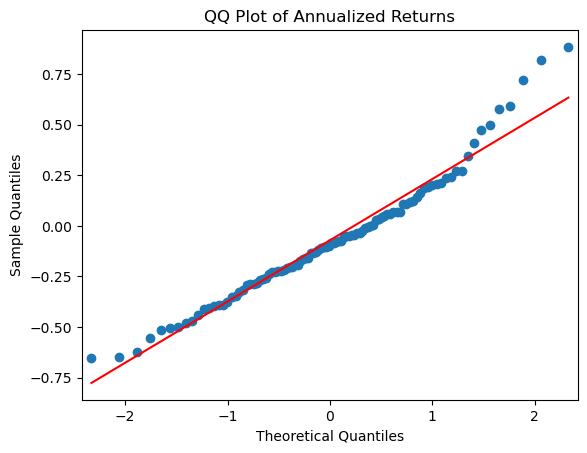

<Figure size 600x600 with 0 Axes>

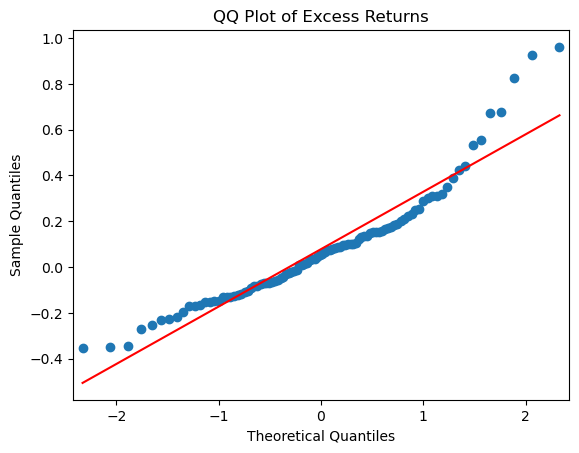

Annualized Returns:
Kurtosis: 3.8873797215205146
Skewness: 0.7274615763641649

Excess Returns:
Kurtosis: 5.175062942103731
Skewness: 1.2332202431593202
Annualized Returns Normality Test:
Is Normal Distribution: No

Excess Returns Normality Test:
Is Normal Distribution: No


In [51]:
from scipy.stats import kurtosis, skew, norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming df_stock_data_with_ann_return contains the 'ann_return' column
# and df_stock_data_with_excess_return contains the 'Excess Return' column
annualized_returns = df_stock_data['ann_return']
excess_returns = df_stock_data['Excess Return']

# Calculate kurtosis and skewness for annualized returns
kurt_ann = kurtosis(annualized_returns, fisher=False)
skw_ann = skew(annualized_returns)

# Calculate kurtosis and skewness for excess returns
kurt_excess = kurtosis(excess_returns, fisher=False)
skw_excess = skew(excess_returns)

# Generate QQ plot for annualized returns
plt.figure(figsize=(6, 6))
sm.qqplot(annualized_returns, line ='s', dist=norm)
plt.title('QQ Plot of Annualized Returns')
plt.show()

# Generate QQ plot for excess returns
plt.figure(figsize=(6, 6))
sm.qqplot(excess_returns, line ='s', dist=norm)
plt.title('QQ Plot of Excess Returns')
plt.show()

# Print kurtosis and skewness results
print("Annualized Returns:")
print(f"Kurtosis: {kurt_ann}")
print(f"Skewness: {skw_ann}")

print("\nExcess Returns:")
print(f"Kurtosis: {kurt_excess}")
print(f"Skewness: {skw_excess}")

# Check for normality in annualized returns (significant kurtosis or skew)
is_normal_distribution_annualized = 'Yes' if kurt_ann < 3 and skw_ann < 0.5 and skw_ann > -0.5 else 'No'

# Check for normality in excess returns
is_normal_distribution_excess = 'Yes' if kurt_excess < 3 and skw_excess < 0.5 and skw_excess > -0.5 else 'No'

# Print the normality test results
print("Annualized Returns Normality Test:")
print(f"Is Normal Distribution: {is_normal_distribution_annualized}")

print("\nExcess Returns Normality Test:")
print(f"Is Normal Distribution: {is_normal_distribution_excess}")


/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


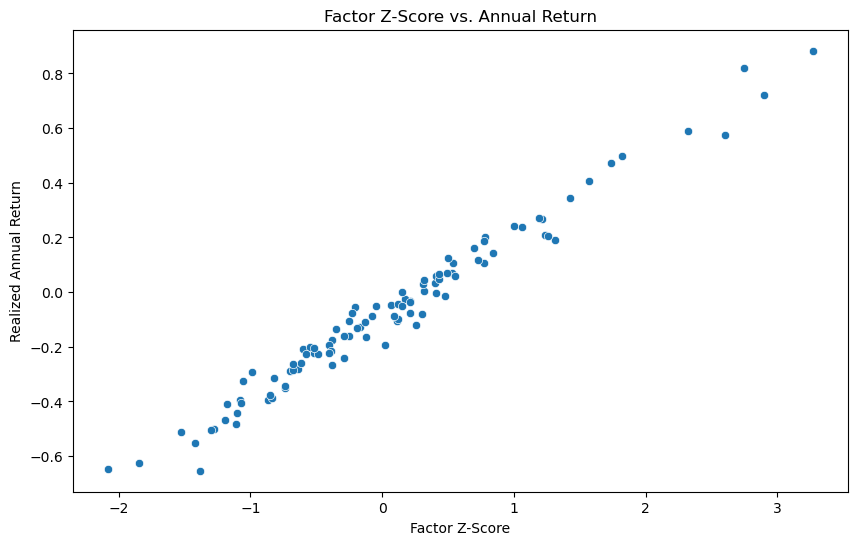

In [66]:
# Assuming df_stock_data contains 'FactorZScore' and 'ann_return' columns
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_stock_data['FactorZScore'], y=df_stock_data['ann_return'])
plt.title('Factor Z-Score vs. Annual Return')
plt.xlabel('Factor Z-Score')
plt.ylabel('Realized Annual Return')
plt.show()


/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


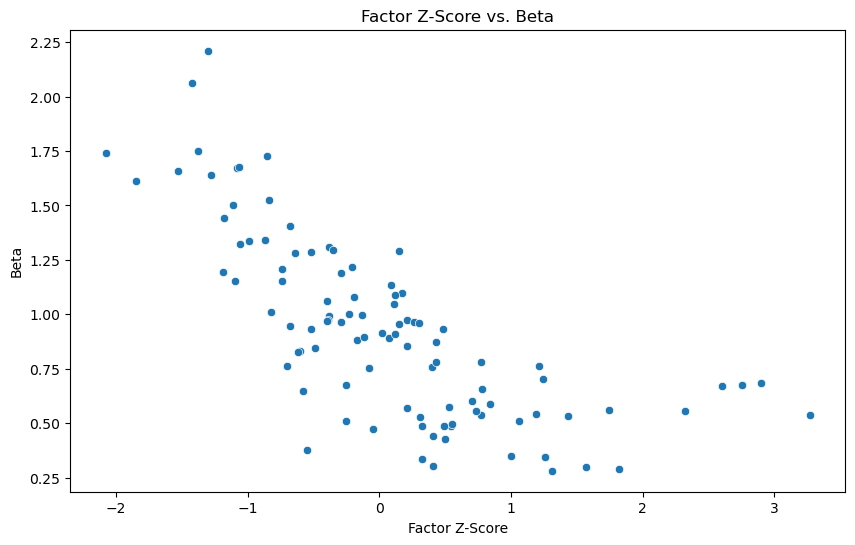

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_stock_data is the DataFrame that contains both 'FactorZScore' and 'Beta' columns
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_stock_data['FactorZScore'], y=df_stock_data['Beta'])
plt.title('Factor Z-Score vs. Beta')
plt.xlabel('Factor Z-Score')
plt.ylabel('Beta')
plt.show()


/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/neilgrigg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

AttributeError: 'Axes' object has no attribute 'legend_elements'

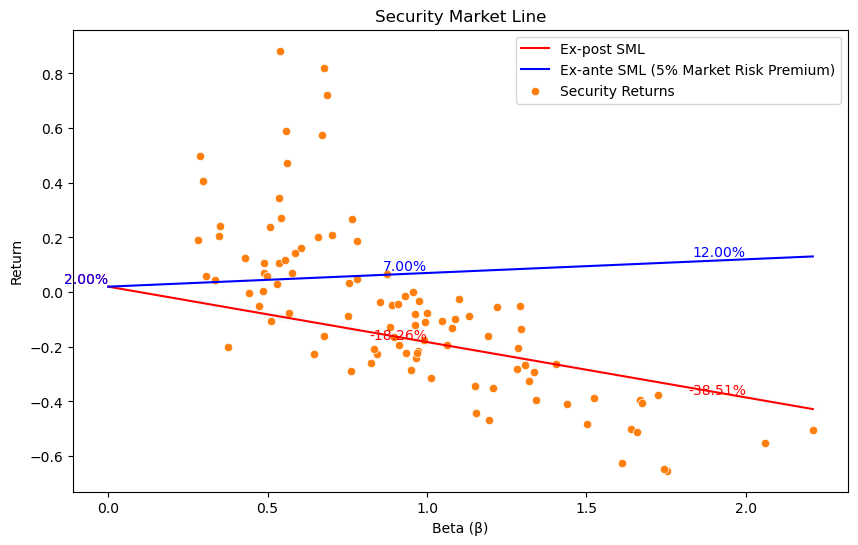

In [54]:
def calculate_expected_return_per_stock(beta, market_annualized_return, risk_free_rate=0.02):
    """
    Calculate the expected return of a stock based on CAPM.

    :param beta: Beta of the stock.
    :param market_annualized_return: Annualized return of the market index.
    :param risk_free_rate: Risk-free rate.
    :return: Expected return of the stock.
    """
    return risk_free_rate + beta * (market_annualized_return - risk_free_rate)

# Calculate total return of the index
index_annualized_return = calculate_annualized_return(df_index_returns['Return'])

# Calculate expected return for each stock using CAPM
df_stock_data['Expected Return'] = df_stock_data.apply(
    lambda row: calculate_expected_return_per_stock(row['Beta'], index_annualized_return), axis=1
)

def plot_security_market_line(df):
    plt.figure(figsize=(10, 6))

    # Ex-post SML: Scatter plot of Beta vs Expected Return (make dots nearly invisible)
    sns.scatterplot(x=df['Beta'], y=df['Expected Return'], alpha=0.01)

    # Ex-post SML: Regression line
    slope = (np.mean(df['Expected Return']) - 0.02) / np.mean(df['Beta'])
    max_beta = df['Beta'].max()
    ex_post_line, = plt.plot([0, max_beta], [0.02, 0.02 + slope * max_beta], color='red', label='Ex-post SML')

    # Ex-ante SML: Line with market risk premium of 5%
    ex_ante_line, = plt.plot([0, max_beta], [0.02, 0.02 + 0.05 * max_beta], color='blue', label='Ex-ante SML (5% Market Risk Premium)')

    # Plot actual realized annual returns of securities
    security_returns = sns.scatterplot(x=df['Beta'], y=df['ann_return'], label='Security Returns')

    # Adding labels for specific beta points on both SMLs
    for beta in [0, 1, 2]:
        plt.text(beta, 0.02 + slope * beta, f'{0.02 + slope * beta:.2%}', color='red', ha='right', va='bottom')
        plt.text(beta, 0.02 + 0.05 * beta, f'{0.02 + 0.05 * beta:.2%}', color='blue', ha='right', va='bottom')

    plt.title('Security Market Line')
    plt.xlabel('Beta (β)')
    plt.ylabel('Return')
    plt.legend(handles=[ex_post_line, ex_ante_line, security_returns.legend_elements()[0][0]])
    plt.show()

# Apply the function to your DataFrame
plot_security_market_line(df_stock_data)



In [55]:
def calculate_alpha(df):
    df['alpha'] = df['ann_return'] - df['Expected Return']
    return df

# Calculate alpha for all stocks in df_stock_data_with_beta
df_stock_data = calculate_alpha(df_stock_data)

# Display the top 5 stocks with the most alpha
top_5_alpha_stocks = df_stock_data.nlargest(5, 'alpha')
print(top_5_alpha_stocks[['Symbol', 'alpha']])

# Display the top 5 stocks with the least alpha
top_5_alpha_stocks = df_stock_data.nsmallest(5, 'alpha')
print(top_5_alpha_stocks[['Symbol', 'alpha']])

   Symbol     alpha
7     XOM  0.971884
97    SLB  0.938031
53    COP  0.840759
98    EOG  0.690232
16    CVX  0.683365
   Symbol     alpha
84   PYPL -0.318569
5    TSLA -0.318392
10   META -0.312234
73   INTC -0.247254
29    DIS -0.228216


In [56]:
def calculate_daily_excess_returns(df_stock_returns, df_index_returns, beta, stock, riskfree=0.02):
    # Ensure 'Dates' column in stock_returns is in datetime format
    df_stock_returns['Dates'] = pd.to_datetime(df_stock_returns['Dates'])

    index_returns_date_column = 'Date'
    riskfree_daily = (1 + riskfree) ** (1 / 252) - 1
    
    # Ensure the date column in index_returns is in datetime format
    df_index_returns[index_returns_date_column] = pd.to_datetime(df_index_returns[index_returns_date_column])

    # Join stock_returns with index_returns on Dates
    aligned_data = df_stock_returns.join(df_index_returns.set_index(index_returns_date_column), on='Dates', how='inner')
    excess_returns = aligned_data[stock] - beta * aligned_data['Return'] - riskfree_daily
    return excess_returns

# Create a new DataFrame for storing excess returns
df_stock_excess_returns = pd.DataFrame()

# Iterate over each stock
for stock in df_stock_data['Symbol']:
    if stock in df_stock_returns.columns:
        stock_returns = df_stock_returns[['Dates', stock]].copy()
        beta = df_stock_data.loc[df_stock_data['Symbol'] == stock, 'Beta'].iloc[0]
        excess_returns_series = calculate_daily_excess_returns(df_stock_returns, df_index_returns, beta, stock)
        
        # Add the excess returns to the new DataFrame
        df_stock_excess_returns[stock] = excess_returns_series

        
df_stock_excess_returns.head

<bound method NDFrame.head of          AAPL      MSFT     GOOGL      AMZN     BRK/B      TSLA      NVDA  \
0    0.016582 -0.012932 -0.007683  0.011574  0.001086  0.124062  0.009961   
1   -0.012036 -0.016505 -0.003407 -0.016073  0.026078 -0.040927 -0.026425   
2   -0.001416 -0.013682 -0.020013  0.012718  0.019027 -0.019710 -0.014943   
3   -0.015605 -0.006836  0.000919 -0.005326  0.011244 -0.020039  0.022687   
4    0.005968  0.005394 -0.000187  0.001978  0.023789 -0.028750 -0.024569   
..        ...       ...       ...       ...       ...       ...       ...   
246 -0.010588 -0.005377  0.008753  0.007673  0.008018 -0.027959 -0.021784   
247 -0.008698 -0.002334 -0.015300 -0.019407 -0.000106 -0.107124 -0.062544   
248 -0.015056  0.005078  0.000375  0.004934  0.002062  0.054052  0.020452   
249  0.005240  0.004981  0.004547 -0.000092  0.005180  0.049932  0.001434   
250  0.005632 -0.001836  0.000763  0.001850  0.001277  0.015428  0.006154   

          XOM         V       UNH  ...       

In [57]:
# Run the add_annualized_volatility function
annualized_vol_df = add_annualized_volatility(df_stock_excess_returns)

# Check the column names and rename the appropriate column to 'Idio Vol'
# This assumes that the annualized volatility column is the second column in annualized_vol_df
volatility_column_name = annualized_vol_df.columns[1]  # Adjust the index [1] if necessary
annualized_vol_df.rename(columns={volatility_column_name: 'Idio Vol'}, inplace=True)

# Merge the annualized volatility into df_stock_data
# Assuming 'Symbol' is a common column in both dataframes
df_stock_data = pd.merge(df_stock_data, annualized_vol_df, on='Symbol', how='left')
df_stock_data

,Symbol,Price,MarketCap,ShareOutstanding,EPS,FactorZScore,equal_weight,ann_vol,P/E Ratio,ann_return,sharpe_ratio,vol_weight,market_cap_weight,Beta,Excess Return,Expected Return,alpha,Idio Vol
0,AAPL,151.01,2389273,15822,6.199,-0.38,0.01,0.356964,24.360381,-0.265843,-0.800760,0.008743,0.101539,1.307697,-0.047090,-0.244906,-0.020936,0.165760
1,MSFT,263.10,1958465,7444,9.934,-0.64,0.01,0.353120,26.484800,-0.282053,-0.855384,0.008839,0.083230,1.282991,-0.067811,-0.239902,-0.042151,0.168782
2,GOOGL,94.57,563259,5956,5.649,-0.87,0.01,0.386506,16.741016,-0.393310,-1.069349,0.008075,0.023937,1.342847,-0.168140,-0.252027,-0.141283,0.209749
3,AMZN,97.61,1000235,10247,2.727,-1.28,0.01,0.500773,35.793913,-0.498907,-1.036212,0.006233,0.042508,1.640393,-0.219413,-0.312302,-0.186605,0.305780
4,BRK/B,309.89,403471,1302,15.222,0.40,0.01,0.225545,20.358034,0.033384,0.059342,0.013838,0.017147,0.755812,0.151376,-0.133108,0.166493,0.132224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,REGN,757.61,81449,108,41.455,0.84,0.01,0.337029,18.275479,0.143673,0.366949,0.009261,0.003461,0.586137,0.230686,-0.098737,0.242409,0.305792
96,PGR,138.73,81143,585,6.532,1.19,0.01,0.257309,21.238518,0.270395,0.973129,0.012130,0.003448,0.543192,0.349568,-0.090037,0.360432,0.221276
97,SLB,56.36,80042,1420,3.026,2.75,0.01,0.498097,18.625248,0.820792,1.607704,0.006266,0.003402,0.677474,0.924482,-0.117239,0.938031,0.470399
98,EOG,134.14,78792,587,13.539,2.60,0.01,0.449031,9.907674,0.574550,1.234993,0.006951,0.003348,0.669787,0.676836,-0.115682,0.690232,0.418818


In [58]:
# Calculate the Information Ratio for each stock
df_stock_data['Information Ratio'] = df_stock_data['alpha'] / df_stock_data['Idio Vol']

# Display the top 20 stocks with the most Information Ratio and their Alphas
top_20_info_ratio_stocks = df_stock_data.nlargest(20, 'Information Ratio')
print("Top 20 Stocks by Information Ratio:")
print(top_20_info_ratio_stocks[['Symbol', 'Information Ratio', 'alpha']])

# Display the bottom 20 stocks with the least Information Ratio and their Alphas
bottom_20_info_ratio_stocks = df_stock_data.nsmallest(20, 'Information Ratio')
print("\nBottom 20 Stocks by Information Ratio:")
print(bottom_20_info_ratio_stocks[['Symbol', 'Information Ratio', 'alpha']])


Top 20 Stocks by Information Ratio:
   Symbol  Information Ratio     alpha
7     XOM           2.982304  0.971884
20    MRK           2.876476  0.537058
90     CI           2.502226  0.565257
16    CVX           2.274493  0.683365
53    COP           2.129043  0.840759
97    SLB           1.994118  0.938031
15    LLY           1.807620  0.433840
66    LMT           1.763198  0.448310
98    EOG           1.648046  0.690232
96    PGR           1.628880  0.360432
51    RTX           1.534398  0.315284
89     CB           1.487977  0.263693
76   GILD           1.445479  0.320955
21   ABBV           1.419176  0.293721
37   TMUS           1.374455  0.331213
64     DE           1.347308  0.403029
59   AMGN           1.276605  0.256170
4   BRK/B           1.259171  0.166493
48    BMY           1.236175  0.228715
22     KO           1.181353  0.185924

Bottom 20 Stocks by Information Ratio:
   Symbol  Information Ratio     alpha
73   INTC          -0.982213 -0.247254
29    DIS          -0.93360

In [65]:
# Extract the factor loading z-scores
factor_loading_zscores = df_stock_data.set_index('Symbol')['FactorZScore']

# Extract the weights and ensure they are indexed by 'Symbol'
equal_weights = df_stock_data.set_index('Symbol')['equal_weight']
vol_weights = df_stock_data.set_index('Symbol')['vol_weight']
market_cap_weights = df_stock_data.set_index('Symbol')['market_cap_weight']

# Multiply the factor loading z-scores by each set of weights
weighted_zscores_equal_weight = factor_loading_zscores.multiply(equal_weights)
weighted_zscores_vol_weight = factor_loading_zscores.multiply(vol_weights)
weighted_zscores_market_cap_weight = factor_loading_zscores.multiply(market_cap_weights)

# Calculate the arithmetic mean for each weighting scheme
mean_zscore_equal_weight = weighted_zscores_equal_weight.mean()
mean_zscore_vol_weight = weighted_zscores_vol_weight.mean()
mean_zscore_market_cap_weight = weighted_zscores_market_cap_weight.mean()

# Save the calculated means into df_portfolio_data
df_portfolio_data.loc['Equal Weight', 'Mean Factor Loading Z-Score'] = mean_zscore_equal_weight
df_portfolio_data.loc['Volatility Weight', 'Mean Factor Loading Z-Score'] = mean_zscore_vol_weight
df_portfolio_data.loc['Market Cap Weight', 'Mean Factor Loading Z-Score'] = mean_zscore_market_cap_weight

# Sample styling assuming a professional color scheme
style = df_portfolio_data.style.set_table_styles(
    [
        {'selector': 'th', 'props': [('font-size', '12pt'), 
                                     ('text-align', 'center'),
                                     ('font-weight', 'bold'),
                                     ('color', '#FFFFFF'),
                                     ('background-color', '#4B8BBE')]},
        {'selector': 'td', 'props': [('font-size', '11pt'), 
                                     ('text-align', 'center'),
                                     ('color', '#333333'),
                                     ('background-color', '#E5E7E9')]},
    ]
).set_properties(**{'font-family': 'Arial, sans-serif'})

# To display in Jupyter Notebook
style

# Display the DataFrame
df_portfolio_data

,ann_return,ann_volatility,sharpe_ratio,Harmonic Mean P/E,Mean Factor Loading Z-Score,Market Correlation,Market Beta,Annualized Tracking Error
Equal Weight,-0.084707,0.226386,-0.462513,17.956437,0.000595,0.992061,0.928988,0.033180
Volatility Weight,-0.040105,0.204311,-0.294183,17.295909,0.001869,0.980385,0.828534,0.057676
Market Cap Weight,-0.146779,0.249234,-0.669168,19.441343,-0.000903,0.996289,1.027104,0.022386


In [60]:
def calculate_correlation(portfolio_returns, market_returns):
    """
    Calculate the correlation of a portfolio relative to the market.
    """
    correlation_matrix = np.corrcoef(portfolio_returns, market_returns)
    correlation = correlation_matrix[0, 1]
    return correlation

# Extracting market returns and setting the index to 'Date'
market_returns = df_index_returns.set_index('Date')['Return']

# Since 'Date' is the index in df_portfolio_returns, you can directly reindex it using the market returns index
aligned_portfolio_returns = df_portfolio_returns.reindex(market_returns.index)

# Calculate correlations for each portfolio type
correlation_equal_weight = calculate_correlation(aligned_portfolio_returns['Equal Weight'], market_returns)
correlation_vol_weight = calculate_correlation(aligned_portfolio_returns['Volatility Weight'], market_returns)
correlation_market_cap_weight = calculate_correlation(aligned_portfolio_returns['Market Cap Weight'], market_returns)

# Add the calculated correlations to df_portfolio_data
df_portfolio_data.loc['Equal Weight', 'Market Correlation'] = correlation_equal_weight
df_portfolio_data.loc['Volatility Weight', 'Market Correlation'] = correlation_vol_weight
df_portfolio_data.loc['Market Cap Weight', 'Market Correlation'] = correlation_market_cap_weight

# Display the updated DataFrame
print(df_portfolio_data)



                   ann_return  ann_volatility  sharpe_ratio  \
Equal Weight        -0.084707        0.226386     -0.462513   
Volatility Weight   -0.040105        0.204311     -0.294183   
Market Cap Weight   -0.146779        0.249234     -0.669168   

                   Harmonic Mean P/E  Mean Factor Loading Z-Score  \
Equal Weight               17.956437                          NaN   
Volatility Weight          17.295909                     0.001869   
Market Cap Weight          19.441343                    -0.000903   

                   Market Correlation  
Equal Weight                 0.992061  
Volatility Weight            0.980385  
Market Cap Weight            0.996289  


In [61]:
# Calculate beta for each portfolio type
beta_equal_weight = calculate_beta(aligned_portfolio_returns['Equal Weight'], market_returns)
beta_vol_weight = calculate_beta(aligned_portfolio_returns['Volatility Weight'], market_returns)
beta_market_cap_weight = calculate_beta(aligned_portfolio_returns['Market Cap Weight'], market_returns)

# Add the calculated betas to df_portfolio_data
df_portfolio_data.loc['Equal Weight', 'Market Beta'] = beta_equal_weight
df_portfolio_data.loc['Volatility Weight', 'Market Beta'] = beta_vol_weight
df_portfolio_data.loc['Market Cap Weight', 'Market Beta'] = beta_market_cap_weight

# Display the updated DataFrame
print(df_portfolio_data)

                   ann_return  ann_volatility  sharpe_ratio  \
Equal Weight        -0.084707        0.226386     -0.462513   
Volatility Weight   -0.040105        0.204311     -0.294183   
Market Cap Weight   -0.146779        0.249234     -0.669168   

                   Harmonic Mean P/E  Mean Factor Loading Z-Score  \
Equal Weight               17.956437                          NaN   
Volatility Weight          17.295909                     0.001869   
Market Cap Weight          19.441343                    -0.000903   

                   Market Correlation  Market Beta  
Equal Weight                 0.992061     0.928988  
Volatility Weight            0.980385     0.828534  
Market Cap Weight            0.996289     1.027104  


In [62]:
def calculate_annualized_tracking_error(portfolio_returns, benchmark_returns, periods_per_year=252):
    """
    Calculate the annualized tracking error of a portfolio compared to a benchmark.

    :param portfolio_returns: Array or Series of portfolio returns.
    :param benchmark_returns: Array or Series of benchmark returns.
    :param periods_per_year: Number of periods per year (252 for daily, 52 for weekly, 12 for monthly).
    :return: Annualized tracking error.
    """
    # Calculate the difference in returns
    active_returns = portfolio_returns - benchmark_returns

    # Calculate the standard deviation of the active returns
    std_dev_active_returns = np.std(active_returns)

    # Annualize the standard deviation
    annualized_tracking_error = std_dev_active_returns * np.sqrt(periods_per_year)

    return annualized_tracking_error

# Calculate annualized tracking error for each portfolio type
tracking_error_equal_weight = calculate_annualized_tracking_error(aligned_portfolio_returns['Equal Weight'], market_returns)
tracking_error_vol_weight = calculate_annualized_tracking_error(aligned_portfolio_returns['Volatility Weight'], market_returns)
tracking_error_market_cap_weight = calculate_annualized_tracking_error(aligned_portfolio_returns['Market Cap Weight'], market_returns)

# Add the calculated tracking errors to df_portfolio_data
df_portfolio_data.loc['Equal Weight', 'Annualized Tracking Error'] = tracking_error_equal_weight
df_portfolio_data.loc['Volatility Weight', 'Annualized Tracking Error'] = tracking_error_vol_weight
df_portfolio_data.loc['Market Cap Weight', 'Annualized Tracking Error'] = tracking_error_market_cap_weight

# Display the updated DataFrame
print(df_portfolio_data)

                   ann_return  ann_volatility  sharpe_ratio  \
Equal Weight        -0.084707        0.226386     -0.462513   
Volatility Weight   -0.040105        0.204311     -0.294183   
Market Cap Weight   -0.146779        0.249234     -0.669168   

                   Harmonic Mean P/E  Mean Factor Loading Z-Score  \
Equal Weight               17.956437                          NaN   
Volatility Weight          17.295909                     0.001869   
Market Cap Weight          19.441343                    -0.000903   

                   Market Correlation  Market Beta  Annualized Tracking Error  
Equal Weight                 0.992061     0.928988                   0.033180  
Volatility Weight            0.980385     0.828534                   0.057676  
Market Cap Weight            0.996289     1.027104                   0.022386  


In [67]:
# Extract the volatility for TSLA
vol_tsla = df_stock_data.loc[df_stock_data['Symbol'] == 'TSLA', 'ann_vol'].iloc[0]

# Assuming you have already calculated the volatility of the equally weighted portfolio
vol_equal_weight = df_portfolio_data['ann_volatility']['Equal Weight']

# Number of stocks in the equally weighted portfolio
num_stocks = len(df_stock_data)

# Define a function to calculate portfolio volatility
def portfolio_volatility(w1, w2, vol1, vol2, correlation):
    return np.sqrt(w1**2 * vol1**2 + w2**2 * vol2**2 + 2 * w1 * w2 * vol1 * vol2 * correlation)

# Assuming correlation between TSLA and the equally weighted portfolio is calculated
correlation_tsla_equal_weight = calculate_correlation(df_stock_returns['TSLA'], df_portfolio_returns['Equal Weight'])

# Calculate portfolio volatility for the portfolio with TSLA and equally weighted portfolio
vol_with_tsla = portfolio_volatility(0, 1, vol_tsla, vol_equal_weight, correlation_tsla_equal_weight)

# Calculate portfolio volatility for the portfolio neutralizing TSLA position
vol_neutral_tsla = portfolio_volatility(-1/num_stocks, 1, vol_tsla, vol_equal_weight, correlation_tsla_equal_weight)

print("vol_with_tsla",vol_with_tsla)
print("vol_neutral_tsla",vol_neutral_tsla)
print("tsla impact on vol",vol_with_tsla-vol_neutral_tsla)

vol_with_tsla 0.22638631624642483
vol_neutral_tsla 0.2224691218996257
tsla impact on vol 0.00391719434679913
